In [ ]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
import pandas as pd
import os.path
from sklearn.preprocessing import StandardScaler


unscaled_df = pd.read_csv('final.csv')
unscaled_df.sort_values(by=['ds'], inplace=True)
unscaled_df = unscaled_df[['ds', 'y', 'holidays', 'snow_1h', 'rain_1h']]
df = unscaled_df.copy()
df['ds'] = pd.to_datetime(df['ds'])
df.fillna(0, inplace=True)

df.shape

# Standard Scale numeric data
scaler = StandardScaler()
#numeric_cols = ['y', 'trend', 'daily', 'weekly', 'yearly', 'holidays', 'snow_1h', 'rain_1h']
numeric_cols = ['y', 'holidays', 'snow_1h', 'rain_1h']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 1months of testing
train_df = df[df['ds'] <= '2018-09-01']
train_df.set_index('ds', inplace=True)
test_df = df[df['ds'] > '2018-09-01']
test_df.set_index('ds', inplace=True)

df.set_index('ds', inplace=True)

In [ ]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
import os.path
from sklearn.preprocessing import normalize


# Intialize h2o
h2o.init()

# create H2O Frame
train_hdf = h2o.H2OFrame(train_df)
test_hdf = h2o.H2OFrame(test_df)
full_hdf = h2o.H2OFrame(df)

# Define Autoencoder
model = H2OAutoEncoderEstimator(
    hidden=[100, 90, 100],
    activation='tanhwithdropout',
    l1=1e-5,
    sparse=True,
    autoencoder=True,
    epochs = 10000
)

# Build deep learning model
model.train(x=train_hdf.names, training_frame=train_hdf)

print(model)

In [ ]:
# determine the model reconstruction error
reconstruction_error = model.anomaly(train_hdf, per_feature=True)
print(reconstruction_error)

dependent_col = 'y'

re_df = reconstruction_error.as_data_frame()
re_df.columns = re_df.columns.str.replace('reconstr_','')
re_df.columns = re_df.columns.str.replace('.SE','_error')


predictions = model.predict(full_hdf)

p_df = predictions.as_data_frame()
p_df.columns = p_df.columns.str.replace('reconstr_','')
# unscale data
p_df[numeric_cols] = scaler.inverse_transform(p_df[numeric_cols])
p_df = p_df.add_suffix('_expected')

final_df = unscaled_df.join(re_df)
final_df = final_df.join(p_df)
final_df.to_csv('traffic.csv', index=False)
final_df['ds'] = pd.to_datetime(final_df['ds'])
final_df.sort_values(by=['ds'], inplace=True)
final_df = final_df[final_df['ds'] >= '2015-06-12']
final_df.set_index('ds', inplace=True)

# RMSE of sales dollar amount
preds = final_df[f'{dependent_col}_expected']
actual = final_df[dependent_col]
final_df[[dependent_col, f'{dependent_col}_expected']].plot()
rmse = ((preds - actual) ** 2).mean() ** .5
print(f'RMSE: {rmse}')

from sklearn.metrics import r2_score
r2 = r2_score(actual, preds)
print(f'R^2: {r2}')

final_df.reset_index(inplace=True)
final_df = final_df[final_df['ds'] > '2018-09-21']
final_df.set_index('ds', inplace=True)
final_df[[dependent_col, f'{dependent_col}_expected']].plot()

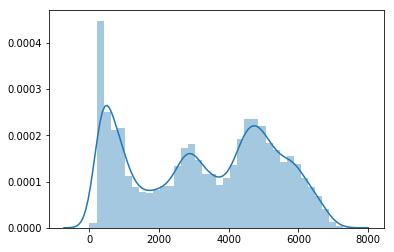

In [4]:
import pandas as pd
import seaborn as sns
%matplotlib inline

df = pd.read_csv('traffic.csv')
sns.distplot(df[['y']])

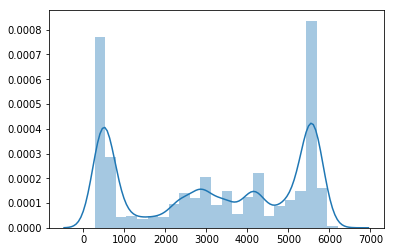

In [5]:
sns.distplot(df[['y_expected']])